In [1]:
# -- Importing necessary modules --

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

In [2]:
# -- Uploading the image on Colab --

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving Screenshot 2025-04-17 153704.png to Screenshot 2025-04-17 153704.png


In [3]:
# -- 1: Preprocessing the image (Conversion from BGR to RGB format) --

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, rgb_image

print(load_and_preprocess_image(image_path))

(array([[[ 32,  32,  32],
        [ 32,  32,  32],
        [ 32,  32,  32],
        ...,
        [ 32,  32,  32],
        [ 32,  32,  32],
        [ 32,  32,  32]],

       [[ 32,  32,  32],
        [220, 220, 220],
        [238, 238, 238],
        ...,
        [240, 241, 241],
        [238, 238, 238],
        [220, 220, 220]],

       [[ 32,  32,  32],
        [240, 240, 240],
        [255, 255, 254],
        ...,
        [236, 233, 229],
        [255, 255, 255],
        [240, 240, 240]],

       ...,

       [[ 32,  32,  32],
        [240, 240, 241],
        [240, 238, 234],
        ...,
        [103, 193,   6],
        [235, 249, 221],
        [241, 239, 243]],

       [[ 32,  32,  32],
        [240, 240, 241],
        [241, 239, 235],
        ...,
        [109, 195,  16],
        [236, 249, 222],
        [241, 239, 243]],

       [[ 32,  32,  32],
        [239, 239, 240],
        [255, 255, 255],
        ...,
        [236, 249, 223],
        [255, 255, 253],
        [240, 239, 240]

In [4]:
# -- 2: Detection of Grid Lines using Hough Transform (Converts points on the image into a parameter space and identifies accumulations to identify the shapes) --

def detect_grid_lines(image):

    # -- Conversion to gray and detection of edges --
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # -- Hough Line Transform --
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    horizontal_lines, vertical_lines = [], []

    # -- Classification of lines into horizontal and vertical based on similarities in x and y coordinates --
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < 10:
                horizontal_lines.append((y1 + y2) // 2)
            elif abs(x2 - x1) < 10:
                vertical_lines.append((x1 + x2) // 2)

    # -- Removal of lines that are too close to each other, keeping only the unique ones --
    def count_unique_lines(lines, tolerance=10):
        lines.sort()
        unique = []
        for l in lines:
            if all(abs(l - u) > tolerance for u in unique):
                unique.append(l)
        return unique

    unique_h = count_unique_lines(horizontal_lines)
    unique_v = count_unique_lines(vertical_lines)

    return unique_h, unique_v

In [5]:
# -- 3: Segmentation of Grid by slicing into smaller rectangles to give us the image crops and coordinates of each unit --

def segment_by_detected_lines(image, h_lines, v_lines):
    grid_cells = []
    grid_coordinates = []

    for i in range(len(h_lines) - 1):
        for j in range(len(v_lines) - 1):
            y1, y2 = h_lines[i], h_lines[i + 1]
            x1, x2 = v_lines[j], v_lines[j + 1]

            # -- Cropping the unit from image and storing its coordinates --
            cell = image[y1:y2, x1:x2]
            grid_cells.append(cell)
            grid_coordinates.append((i, j, x1, y1, x2, y2))

    return grid_cells, grid_coordinates

print(segment_by_detected_lines)

<function segment_by_detected_lines at 0x7b35a15713a0>


In [6]:
# -- 4: Color Detection for Roads and Ground --

def detect_colors(cell):

    # -- Resize the image for consistent sampling --
    resized = cv2.resize(cell, (20, 20))
    pixels = resized.reshape(-1, 3)

    # -- Target colors in BGR (OpenCV uses BGR) --
    gray_bgr = np.array([119, 99, 73])    # -- HEX #496477 --
    green_bgr = np.array([99, 191, 0])    # -- HEX #00BE64 --

    # -- Distance threshold for close-enough color match --
    threshold = 50  # -- Looser threshold helps capture variations --

    # -- Calculate Euclidean distances --
    dist_to_gray = np.linalg.norm(pixels - gray_bgr, axis=1)
    dist_to_green = np.linalg.norm(pixels - green_bgr, axis=1)

    # -- Percentages of pixels matching each target color --
    gray_match_pct = np.sum(dist_to_gray < threshold) / len(pixels) * 100
    green_match_pct = np.sum(dist_to_green < threshold) / len(pixels) * 100

    if gray_match_pct > 80:
        return "road"
    elif green_match_pct > 80:
        return "ground"
    else:
        return "unknown"

In [7]:
# -- 5: Visualize the results from all the previous steps --

def visualize(image, grid_coords, classifications):
    output = image.copy()
    for idx, (row, col, x1, y1, x2, y2) in enumerate(grid_coords):
        label = classifications[idx]

        # -- Labelling the units by different colors upon identification --

        if label == 'road':
            color = (0, 0, 200)  # -- Red for roads (BGR format) --
        elif label == 'ground':
            color = (0, 200, 0)  # -- Green for ground --
        else:  # unknown
            color = (200, 0, 200)  # -- Purple for unknown --

        # -- Overlays the color over the cells at 40% --
        overlay = np.ones_like(output[y1:y2, x1:x2]) * color
        cv2.addWeighted(overlay.astype(np.uint8), 0.4, output[y1:y2, x1:x2], 0.6, 0, output[y1:y2, x1:x2])

        # -- Display first letter of classification (R, G, or U) --
        text_label = label[0].upper()
        cv2.putText(output, text_label, (x1 + 5, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    rgb_out = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_out)
    plt.title("Grid Classification (R = Road, G = Ground, U = Unknown)")
    plt.axis('off')
    plt.show()
    return output

print(visualize)

<function visualize at 0x7b35a15709a0>


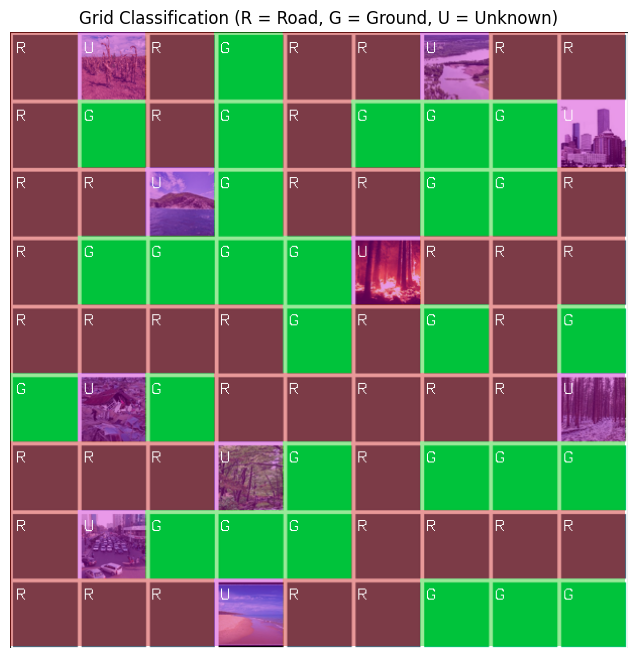


Grid Representation:
R U R G R R U R R
R G R G R G G G U
R R U G R R G G R
R G G G G U R R R
R R R R G R G R G
G U G R R R R R U
R R R U G R G G G
R U G G G R R R R
R R R U R R G G G


In [8]:
# -- 6: Full Processing --

def full_process(image_path):
    image, _ = load_and_preprocess_image(image_path)
    h_lines, v_lines = detect_grid_lines(image)

    if len(h_lines) < 2 or len(v_lines) < 2:
        print("Insufficient grid lines detected.")
        return

    grid_cells, grid_coords = segment_by_detected_lines(image, h_lines, v_lines)
    classifications = [detect_colors(cell) for cell in grid_cells]
    final_image=visualize(image, grid_coords, classifications)

    # -- Matrix representation --
    rep = []
    row_temp = []
    prev_row = grid_coords[0][0]
    for idx, (r, c, *_rest) in enumerate(grid_coords):
        if r != prev_row:
            rep.append(row_temp)
            row_temp = []
            prev_row = r
        if classifications[idx] == "road":
            row_temp.append("R")
        elif classifications[idx] == "ground":
            row_temp.append("G")
        else:
            row_temp.append("U")  # -- Explicitly using U for unknown --
    rep.append(row_temp)

    print("\nGrid Representation:")
    for row in rep:
        print(" ".join(row))

# -- Running the program --
full_process(image_path)

In [9]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 56.3 MB/s eta 0:00:00


In [10]:
# Uses a pretrained MobileNetV2 model to extract deep feature embeddings from an input image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import cv2

IMG_SIZE = 96

# Load pretrained model
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from a single image or cell
def extract_features_from_image(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img.astype(np.float32))
    img = np.expand_dims(img, axis=0)
    features = feature_extractor.predict(img, verbose=0)
    return features.flatten()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Extract feature vectors and assign a label to all valid images in a folder using a pretrained CNN
def extract_features_from_folder(folder_path, label):
    features = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, fname)
                img = cv2.imread(path)
                if img is None:
                    print(f"Skipping unreadable file: {path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                feat = extract_features_from_image(img)
                features.append(feat)
                labels.append(label)
    return features, labels

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os

X_safe, y_safe = extract_features_from_folder('/content/drive/MyDrive/Colab Notebooks/Dataset/Safe', 0)
X_unsafe, y_unsafe = extract_features_from_folder('/content/drive/MyDrive/Colab Notebooks/Dataset/Unsafe', 1)

print("Safe features:", len(X_safe))
print("Unsafe features:", len(X_unsafe))

X = np.vstack(X_safe + X_unsafe).astype('float32')
y = np.array(y_safe + y_unsafe)

print("X shape:", X.shape)



Safe features: 527
Unsafe features: 1155
X shape: (1682, 1280)


In [16]:
# Trains a K-Nearest Neighbors classifier on extracted image features and evaluates its performance on a test set.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming X, y = features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print(classification_report(y_test, knn.predict(X_test)))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88       109
           1       1.00      0.87      0.93       228

    accuracy                           0.91       337
   macro avg       0.89      0.94      0.91       337
weighted avg       0.93      0.91      0.92       337



In [17]:
# Create a FAISS index with L2 distance to enable fast similarity search on image feature vectors
import faiss

def create_faiss_index(features):
    dim = features.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(features.astype('float32'))
    return index

# Build and use FAISS
faiss_index = create_faiss_index(X)

In [18]:

def faiss_classify_cell(cell_img, index, labels):
    # Extract features from the input grid cell
    feat = extract_features_from_image(cell_img).astype('float32').reshape(1, -1)

    # Perform the FAISS search to find the nearest neighbor
    D, I = index.search(feat, 1)

    # Get the predicted label (0 for safe, 1 for unsafe)
    predicted_label = labels[I[0][0]]

    # Return a more interpretable label for display

    if predicted_label == 0:
        return "Safe"
    else:
        return "Unsafe"


In [19]:
# Visualize safety classification on grid cells by overlaying labels and colors on the input image using FAISS and heuristic rules.
def visualize_with_safety(image, grid_coords, grid_cells, classifications, index, labels):
    output = image.copy()
    safety_labels = []


    for idx, (row, col, x1, y1, x2, y2) in enumerate(grid_coords):
        label = classifications[idx]
        safety = "Unknown"

        if label == 'road':
            safety = "Safe"
            color = (0, 255, 0)  # Green
        elif label == 'ground':
            safety = "Unsafe"
            color = (0, 0, 255)  # Red
        else:
            # Use FAISS to classify unknown cells
            faiss_result = faiss_classify_cell(grid_cells[idx], index, labels)
            safety = faiss_result
            color = (0, 255, 0) if safety == "Safe" else (0, 0, 255)

        safety_labels.append(safety)

        # Overlay safety color with transparency
        overlay = np.ones_like(output[y1:y2, x1:x2]) * color
        cv2.addWeighted(overlay.astype(np.uint8), 0.4, output[y1:y2, x1:x2], 0.6, 0, output[y1:y2, x1:x2])

        # Add text label
        text = 'S' if safety == "Safe" else 'U'
        cv2.putText(output, text, (x1 + 5, y1 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    rgb_out = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_out)
    plt.title("Safety Classification (S = Safe, U = Unsafe)")
    plt.axis('off')
    plt.show()


In [20]:
# Perform the full safety classification process by detecting grid lines, segmenting the image, classifying cells, and visualizing the result.
def full_process_with_safety(image_path, index, labels):
    image, _ = load_and_preprocess_image(image_path)
    h_lines, v_lines = detect_grid_lines(image)

    if len(h_lines) < 2 or len(v_lines) < 2:
        print("Insufficient grid lines detected.")
        return None, None, None, None

    grid_cells, grid_coords = segment_by_detected_lines(image, h_lines, v_lines)
    classifications = [detect_colors(cell) for cell in grid_cells]

    visualize_with_safety(image, grid_coords, grid_cells, classifications, index, labels)

    print("\nSafety Grid Summary:")
    prev_row = grid_coords[0][0]
    row_temp = []
    matrix = []

    for idx, (r, c, *_rest) in enumerate(grid_coords):
        # Check if we're moving to a new row
        if r != prev_row:
            print(" ".join(row_temp))    # Print the row
            matrix.append(row_temp)      # Save it to the matrix
            row_temp = []
            prev_row = r

        label = classifications[idx]
        if label == 'road':
            cell_label = 'S'
        elif label == 'ground':
            cell_label = 'U'
        else:
            result = faiss_classify_cell(grid_cells[idx], index, labels)
            cell_label = 'S' if result == "Safe" else 'U'

        row_temp.append(cell_label)

    # Append and print last row
    print(" ".join(row_temp))
    matrix.append(row_temp)

    return grid_coords, grid_cells, classifications, matrix


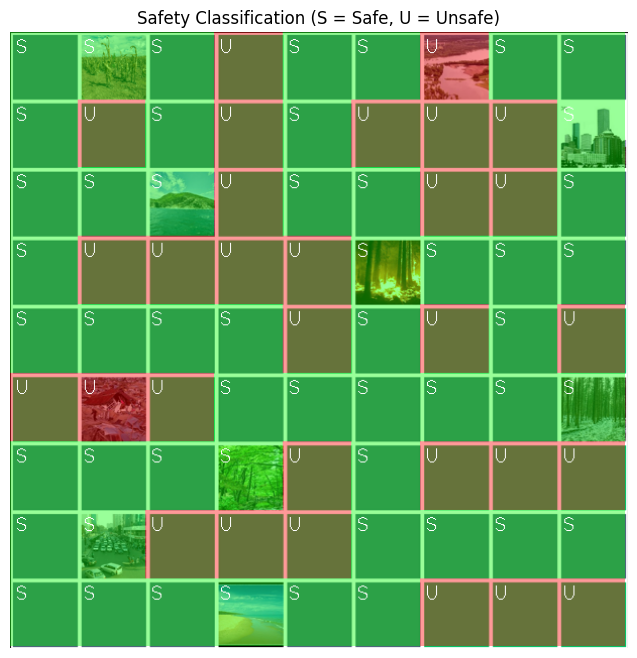


Safety Grid Summary:
S S S U S S U S S
S U S U S U U U S
S S S U S S U U S
S U U U U S S S S
S S S S U S U S U
U U U S S S S S S
S S S S U S U U U
S S U U U S S S S
S S S S S S U U U


In [21]:

grid_coords, grid_cells, classifications, city_matrix = full_process_with_safety(image_path, faiss_index, y)

In [22]:
# Convert the safety classification matrix into a binary matrix where 'S' (Safe) is 1 and 'U' (Unsafe) is 0.
def convert_to_binary_matrix(city_matrix):
    return [[1 if cell == 'S' else 0 for cell in row] for row in city_matrix]

binary_matrix = convert_to_binary_matrix(city_matrix)

print("Binary Traversability Matrix:")
for row in binary_matrix:
    print(" ".join(map(str, row)))


Binary Traversability Matrix:
1 1 1 0 1 1 0 1 1
1 0 1 0 1 0 0 0 1
1 1 1 0 1 1 0 0 1
1 0 0 0 0 1 1 1 1
1 1 1 1 0 1 0 1 0
0 0 0 1 1 1 1 1 1
1 1 1 1 0 1 0 0 0
1 1 0 0 0 1 1 1 1
1 1 1 1 1 1 0 0 0


In [23]:
# Implement the A* algorithm to find the optimal path from start to goal on a grid using Manhattan distance as the heuristic.
import heapq

# A* Algorithm Implementation
def heuristic(a, b):
    # Manhattan distance heuristic (optimal for grids)
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(start, goal, grid):
    open_list = []  # Priority queue
    closed_list = set()  # Set of nodes already evaluated
    came_from = {}  # Tracks the best path to each node

    g_score = {start: 0}  # Cost of the path from start to current node
    f_score = {start: heuristic(start, goal)}  # Estimated total cost (g_score + heuristic)

    # Push the starting point to the open list
    heapq.heappush(open_list, (f_score[start], start))

    while open_list:
        # Pop the node with the lowest f_score
        current_f, current = heapq.heappop(open_list)

        # If we've reached the goal, reconstruct the path
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()  # Reverse to get path from start to goal
            return path

        closed_list.add(current)

        # Explore the neighbors of the current node
        for neighbor in get_neighbors(current, grid):
            if neighbor in closed_list:
                continue

            tentative_g_score = g_score[current] + 1  # Every move costs 1

            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)

                # Push the neighbor to the open list for further exploration
                heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return None  # Return None if no path is found

# Get the valid neighbors (up, down, left, right) for A* search
def get_neighbors(node, grid):
    neighbors = []
    x, y = node
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    # Check the 4 possible neighbors
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        # Make sure it's within grid bounds and traversable (1 = safe, 0 = unsafe)
        if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]) and grid[nx][ny] == 1:
            neighbors.append((nx, ny))

    return neighbors


In [24]:
# Prepare the city matrix for A* by converting 'S' (Safe) to 1 and 'U' (Unsafe) to 0, then run A* to find the shortest path.
def prepare_grid_for_astar(city_matrix):
    return [[1 if cell == 'S' else 0 for cell in row] for row in city_matrix]

# Example usage
grid = prepare_grid_for_astar(city_matrix)

# Set start and goal points (bottom-left and top-right)
start = (len(grid) - 1, 0)  # Bottom-left corner (row, col)
goal = (0, len(grid[0]) - 1)  # Top-right corner (row, col)

# Find the shortest path using A*
path = a_star(start, goal, grid)

if path:
    print("Path found:", path)
else:
    print("No path found.")


Path found: [(8, 0), (7, 0), (6, 0), (6, 1), (6, 2), (6, 3), (5, 3), (5, 4), (5, 5), (4, 5), (3, 5), (3, 6), (3, 7), (3, 8), (2, 8), (1, 8), (0, 8)]


In [25]:
# Draw the shortest path on the image by overlaying red rectangles on grid cells that are part of the path.
def draw_path_on_image(image, path, grid_coords):
    output = image.copy()

    for (row, col, x1, y1, x2, y2) in grid_coords:
        # Check if the current grid cell is part of the path
        if (row, col) in path:
            # Draw a red square for the path
            cv2.rectangle(output, (x1, y1), (x2, y2), (0, 0, 255), 2)

    rgb_out = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_out)
    plt.title("Shortest Path on Grid")
    plt.axis('off')
    plt.show()

In [26]:
# Perform the entire process: detect grid lines, classify cells, run A* to find the shortest path, and visualize the result on the image.
def full_process_with_path(image_path, faiss_index, labels):
    image, _ = load_and_preprocess_image(image_path)
    h_lines, v_lines = detect_grid_lines(image)

    if len(h_lines) < 2 or len(v_lines) < 2:
        print("Insufficient grid lines detected.")
        return None, None, None, None

    grid_cells, grid_coords = segment_by_detected_lines(image, h_lines, v_lines)
    classifications = [detect_colors(cell) for cell in grid_cells]

    visualize_with_safety(image, grid_coords, grid_cells, classifications, faiss_index, labels)

    # Prepare the grid and run A* to find the shortest path
    grid = prepare_grid_for_astar(city_matrix)
    start = (len(grid) - 1, 0)  # Bottom-left corner (row, col)
    goal = (0, len(grid[0]) - 1)  # Top-right corner (row, col)

    # Run A* algorithm to find the path
    path = a_star(start, goal, grid)

    if path:
        print("Path found:", path)
        draw_path_on_image(image, path, grid_coords)
    else:
        print("No path found.")


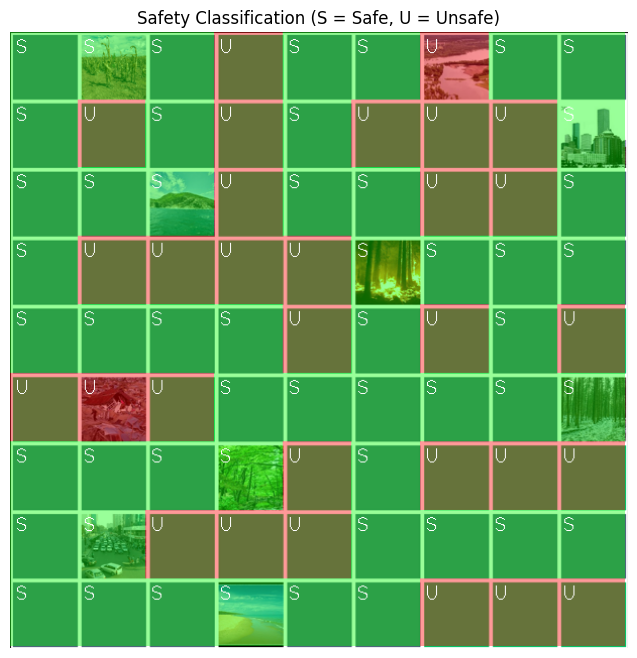

Path found: [(8, 0), (7, 0), (6, 0), (6, 1), (6, 2), (6, 3), (5, 3), (5, 4), (5, 5), (4, 5), (3, 5), (3, 6), (3, 7), (3, 8), (2, 8), (1, 8), (0, 8)]


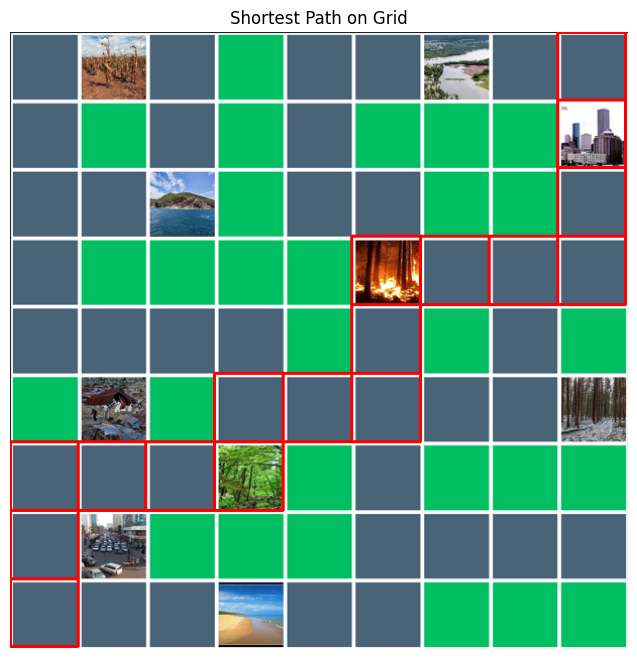

In [27]:
# Run the full process with pathfinding
full_process_with_path(image_path, faiss_index, y)

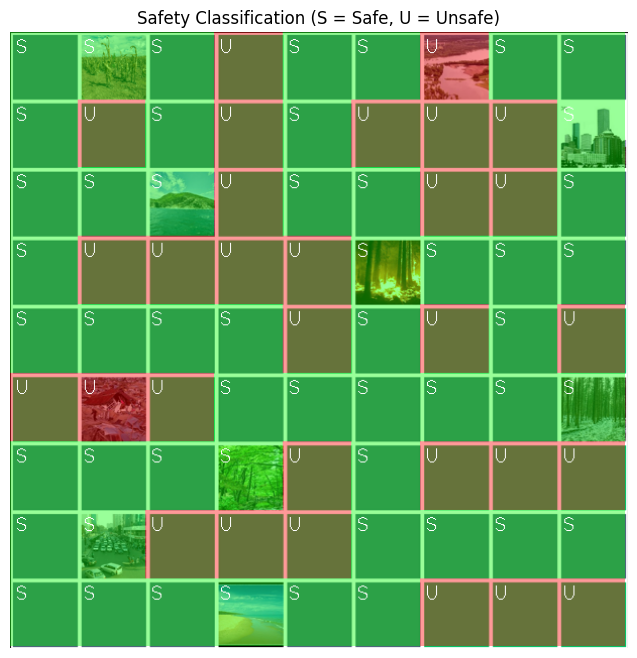

Path found: [(8, 0), (7, 0), (6, 0), (6, 1), (6, 2), (6, 3), (5, 3), (5, 4), (5, 5), (4, 5), (3, 5), (3, 6), (3, 7), (3, 8), (2, 8), (1, 8), (0, 8)]


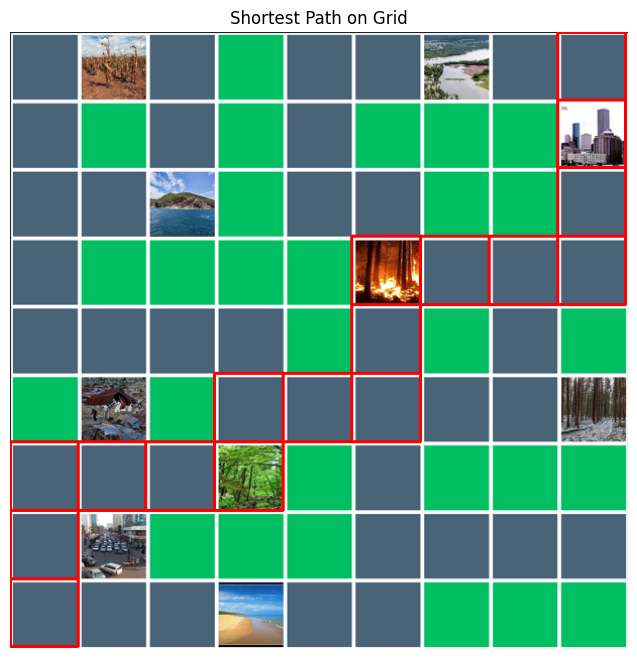

In [28]:
# Animate the traversal of a path on the grid image by drawing the path and adding a pulsing circle for the current position.
def animate_path_traversal(image, path, grid_coords):
    """
    Animate the traversal of a path on the grid image.

    Args:
        image: Original image
        path: List of (row, col) tuples representing the path
        grid_coords: Grid cell coordinates
    """
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import numpy as np
    import cv2
    from IPython.display import HTML

    # Create a figure for the animation
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.axis('off')

    # Initialize a list to store the frames
    frames = []

    # Create a mapping of (row, col) to grid coordinates for faster lookup
    coord_map = {(row, col): (x1, y1, x2, y2) for row, col, x1, y1, x2, y2 in grid_coords}

    # Initialize with the base image
    base_image = image.copy()
    rgb_base = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    # For each step in the path, create a frame
    for i in range(len(path) + 1):
        current_frame = rgb_base.copy()

        # Draw the path up to the current position
        for j in range(min(i, len(path))):
            row, col = path[j]
            if (row, col) in coord_map:
                x1, y1, x2, y2 = coord_map[(row, col)]

                # Current position (head of the path)
                if j == i - 1:
                    # Draw a pulsing circle at the current position
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2
                    radius = min(x2 - x1, y2 - y1) // 4
                    cv2.circle(current_frame, (center_x, center_y), radius, (255, 0, 0), -1)  # Red filled circle

                    # Add a halo effect
                    cv2.circle(current_frame, (center_x, center_y), radius + 5, (255, 255, 0), 2)  # Yellow halo
                else:
                    # Previous positions in the path
                    cv2.rectangle(current_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red outline

                    # Add arrow to show direction if there's a next point
                    if j + 1 < min(i, len(path)):
                        next_row, next_col = path[j + 1]
                        if (next_row, next_col) in coord_map:
                            next_x1, next_y1, next_x2, next_y2 = coord_map[(next_row, next_col)]

                            # Calculate centers of current and next cells
                            curr_center = ((x1 + x2) // 2, (y1 + y2) // 2)
                            next_center = ((next_x1 + next_x2) // 2, (next_y1 + next_y2) // 2)

                            # Draw arrow from current to next
                            cv2.arrowedLine(current_frame, curr_center, next_center,
                                          (255, 165, 0), 2, tipLength=0.3)  # Orange arrow

        # Add a title showing the step number
        if i == 0:
            title = "Starting Path Animation"
        elif i == len(path):
            title = f"Path Complete: {len(path)} steps"
        else:
            title = f"Step {i} of {len(path)}"

        # Add the frame to our list
        frames.append([ax.imshow(current_frame, animated=True)])
        ax.set_title(title)

    # Create the animation
    ani = animation.ArtistAnimation(fig, frames, interval=300, blit=True)
    plt.close()  # Close the figure to prevent duplicate display

    return HTML(ani.to_jshtml())

# Modified full_process_with_path function to include animation
def full_process_with_animated_path(image_path, faiss_index, labels):
    image, _ = load_and_preprocess_image(image_path)
    h_lines, v_lines = detect_grid_lines(image)

    if len(h_lines) < 2 or len(v_lines) < 2:
        print("Insufficient grid lines detected.")
        return None, None, None, None

    grid_cells, grid_coords = segment_by_detected_lines(image, h_lines, v_lines)
    classifications = [detect_colors(cell) for cell in grid_cells]

    visualize_with_safety(image, grid_coords, grid_cells, classifications, faiss_index, labels)

    # Build the traversability matrix
    city_matrix = []
    prev_row = grid_coords[0][0]
    row_temp = []

    for idx, (r, c, *_rest) in enumerate(grid_coords):
        # Check if we're moving to a new row
        if r != prev_row:
            city_matrix.append(row_temp)
            row_temp = []
            prev_row = r

        label = classifications[idx]
        if label == 'road':
            cell_label = 'S'
        elif label == 'ground':
            cell_label = 'U'
        else:
            result = faiss_classify_cell(grid_cells[idx], faiss_index, labels)
            cell_label = 'S' if result == "Safe" else 'U'

        row_temp.append(cell_label)

    # Append last row
    city_matrix.append(row_temp)

    # Prepare the grid and run A* to find the shortest path
    grid = prepare_grid_for_astar(city_matrix)
    start = (len(grid) - 1, 0)  # Bottom-left corner (row, col)
    goal = (0, len(grid[0]) - 1)  # Top-right corner (row, col)

    # Run A* algorithm to find the path
    path = a_star(start, goal, grid)

    if path:
        print("Path found:", path)
        # First show the static path visualization
        draw_path_on_image(image, path, grid_coords)
        # Then return the animation
        return animate_path_traversal(image, path, grid_coords)
    else:
        print("No path found.")
        return None

# Usage
animation_html = full_process_with_animated_path(image_path, faiss_index, y)
# Display the animation if a path was found
if animation_html:
    display(animation_html)